In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from   matplotlib.colors import LogNorm
import seaborn
from functools import partial
import pickle
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 150

In [19]:
dark = True
if dark:
    plt.style.use('dark_background')

In [4]:
def generate_normal_time_series(num, minl=50, maxl=1000):
    data = np.array([], dtype=np.float64)
    partition = np.random.randint(minl, maxl, num)
    for p in partition:
        mean = np.random.randn()*10
        var = np.random.randn()*1
        if var < 0:
            var = var * -1
        tdata = np.random.normal(mean, var, p)
        data = np.concatenate((data, tdata))
    return data

In [69]:
def online_changepoint_detection(data, hazard, model):
    # 1. Initialize the posterior probabilities table
    maxes = np.zeros(len(data) + 1)
    R = np.zeros((len(data) + 1, len(data) + 1))
    R[0, 0] = 1
    
    # 2. Observe New Data
    for t, x in enumerate(data):
        #print(t)
        # 3. Evaluate posterior predictive probabilities of new datum for each parameters
        predictive_probabilities = model.predictive_probability(x)
       
        # 4. Calculate growth probabilities.
        R[1 : t + 2, t + 1] = R[0 : t + 1, t] * predictive_probabilities * (1 - hazard)
        
        # 5. Calculate changepoint probabilities.
        prior_predictive_probabilities = model.prior_predictive_probability(x)
        R[0, t + 1] = np.sum(R[0 : t + 1, t] * prior_predictive_probabilities * hazard)
        #R[0, t + 1] = np.sum(R[0 : t + 1, t] * predictive_probabilities * hazard)
        
        # 6. Calculate evidence
        evidence = np.sum(R[:, t + 1])
        
        # 7. Determine posterior run length distribution.
        R[:, t + 1] = R[:, t + 1] / evidence
        
        # 8. Update sufficient statistics for each possible run length
        model.update_statistics(x)
        
        # 9. Calculate maximum a posteriori estimation
        maxes[t+1] = R[:, t+1].argmax()
    return R, maxes

In [6]:
R, maxes = online_changepoint_detection(data, 1/20, IS_Poisson_Gamma(1, 1, 100))

NameError: name 'data' is not defined

In [70]:
class IS_Poisson_Gamma:
    def __init__(self, k, theta, sample_size):
        self.k = np.array([k])
        self.theta = np.array([theta])
        self.sample_size = sample_size
        self.samples0 = self.samples = stats.gamma.rvs(1, loc=self.k, scale=self.theta, size=self.sample_size).reshape(1,-1)
        self.weights0 = self.weights = np.ones(self.sample_size).reshape(1 , -1) / self.sample_size

    def predictive_probability(self, data):
        return np.sum(self.weights * stats.poisson.pmf(data, self.samples), axis=1)

    def update_statistics(self, data):
        S = self.samples0
        w = self.weights0
        
        for S_old, w_old in zip(self.samples, self.weights):
            S_new, w_new = self.importance_sampling(S_old, w_old, data)
            S = np.concatenate((S, S_new))
            w = np.concatenate((w, w_new))

        self.samples = S
        self.weights = w
    
    def importance_sampling(self, S_old, w_old, data):
        size = len(S_old)
        S_old = S_old.reshape(1, -1)
        index = np.random.choice(size, size, p=w_old)
        S_star = S_old[:, index]
        std = 0.1 * np.std(S_old)
        S_new = stats.norm.rvs(loc=S_star, scale=std, size=S_star.shape)
        gauss_kernel = self.gaussian_kernel(S_new, S_old, sigma = std) 
        proposal = (gauss_kernel @ w_old.reshape(-1,1)).T
        target = stats.poisson.pmf(data, S_new) * stats.gamma.pdf(S_new, 1, loc=self.k, scale=self.theta)
        w_new = target / proposal
        w_new = w_new / np.sum(w_new)
        return S_new, w_new
    
    def gaussian_kernel(self, X_A, X_B, sigma):
        inner_X_A = np.einsum("ij,ij->j", X_A, X_A).reshape(-1, 1)
        inner_X_B = np.einsum("ij,ij->j", X_B, X_B).reshape(1, -1)
        inner_M = inner_X_A - 2 * X_A.T @ X_B + inner_X_B
    
        K_AB = np.exp(-inner_M / (2 * sigma**2)) / (np.sqrt(2 * np.pi)*sigma)
        return K_AB

In [71]:
class IS_Poisson_Gamma_new:
    def __init__(self, k, theta, sample_size):
        self.k = np.array([k])
        self.theta = np.array([theta])
        self.sample_size = sample_size
        self.samples0 = self.samples = stats.gamma.rvs(1, loc=self.k, scale=self.theta, size=self.sample_size).reshape(1,-1)
        self.weights0 = self.weights = np.ones(self.sample_size).reshape(1 , -1) / self.sample_size

    def predictive_probability(self, data):
        return np.mean(stats.poisson.pmf(data, self.samples).reshape(1,-1), axis=1)

    def update_statistics(self, data):
        S = self.samples0
        for S_old in self.samples:
            S_new = self.importance_sampling(S_old, data)
            S = np.concatenate((S, S_new))

        self.samples = S
        
    def importance_sampling(self, S, data):
        proposal = stats.gamma.pdf(S, 1, loc=self.k, scale=self.theta)
        target = stats.poisson.pmf(data, S) * stats.gamma.pdf(S, 1, loc=self.k, scale=self.theta)
        w_new = target / proposal
        w_new = w_new / np.sum(w_new)
        S_new = np.random.choice(S, len(S), p=w_new)
        return S_new.reshape(1, -1)

In [72]:
class StudentT:
    def __init__(self, alpha, beta, kappa, mu):
        self.alpha0 = self.alpha = np.array([alpha])
        self.beta0 = self.beta = np.array([beta])
        self.kappa0 = self.kappa = np.array([kappa])
        self.mu0 = self.mu = np.array([mu])

    def predictive_probability(self, data):
        return stats.t.pdf(x=data, 
                           df=2*self.alpha,
                           loc=self.mu,
                           scale=np.sqrt(self.beta * (self.kappa+1) / (self.alpha *
                               self.kappa)))

    def update_statistics(self, data):
        muT0 = np.concatenate((self.mu0, (self.kappa * self.mu + data) / (self.kappa + 1)))
        kappaT0 = np.concatenate((self.kappa0, self.kappa + 1.))
        alphaT0 = np.concatenate((self.alpha0, self.alpha + 0.5))
        betaT0 = np.concatenate((self.beta0, self.beta + (self.kappa * (data -
            self.mu)**2) / (2. * (self.kappa + 1.))))
            
        self.mu = muT0
        self.kappa = kappaT0
        self.alpha = alphaT0
        self.beta = betaT0

In [73]:
class Poisson:
    def __init__(self, k, theta):
        self.k0 = self.k = np.array([k])
        self.theta0 = self.theta = np.array([theta])

    def predictive_probability(self, data):
        return stats.nbinom.pmf(data,self.k, 1/(1+self.theta))
    
    def prior_predictive_probability(self, data):
        return stats.nbinom.pmf(data,self.k0, 1/(1+self.theta0))

    def update_statistics(self, data):
        kT0 = np.concatenate((self.k0, self.k+data))
        thetaT0 = np.concatenate((self.theta0, self.theta/(1+self.theta)))

        self.k = kT0
        self.theta = thetaT0

In [74]:
class Normal:
    def __init__(self, mu, lamb):
        self.mu0 = self.mu = np.array([mu])
        self.lamb0 = self.lamb = np.array([lamb])

    def predictive_probability(self, data):
        return stats.norm.pdf(data, self.mu, 1 + 1/self.lamb)

    def update_statistics(self, data):
        offsets = np.arange(1, len(self.mu)+1)
        muT0 = np.concatenate((self.mu0, (self.mu * offsets + data) / (offsets + 1)))
        lambT0 = np.concatenate((self.lamb0, 1+self.lamb))

        self.mu = muT0
        self.lamb = lambT0

In [50]:
def plot_posterior(T, data, R, cpts, set_cpts=False):
    """Plot data, run length posterior, and groundtruth changepoints.
    """
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    ax1, ax2 = axes

    ax1.scatter(range(0, T), data)
    ax1.plot(range(0, T), data)
    ax1.set_xlim([0, T])
    ax1.margins(0)

    norm = LogNorm(vmin=0.0001, vmax=1)
    if dark:
        ax2.imshow(np.flip(R, axis=0), aspect='auto', cmap='gray', norm=norm)
        #ax2.imshow(np.flip(R, axis=0), aspect='auto', cmap='gray_r', norm=norm)
    else:
        ax2.imshow(np.flip(R, axis=0), aspect='auto', cmap='gray_r', norm=norm)
    ax2.set_xlim([0, T])
    # This just reverses the y-tick marks.
    ticks = list(range(0, T+1, 50))
    ax2.set_yticks(ticks)
    ax2.set_yticklabels(ticks[::-1])
    ax2.margins(0)
    
    if set_cpts:
        for cpt in cpts:
            ax1.axvline(cpt, c='r', ls='dotted')
            ax2.axvline(cpt, c='r', ls='dotted')

    plt.tight_layout()
    plt.savefig('result.pdf',transparent=True)
    plt.show()

# Run the Algorithm

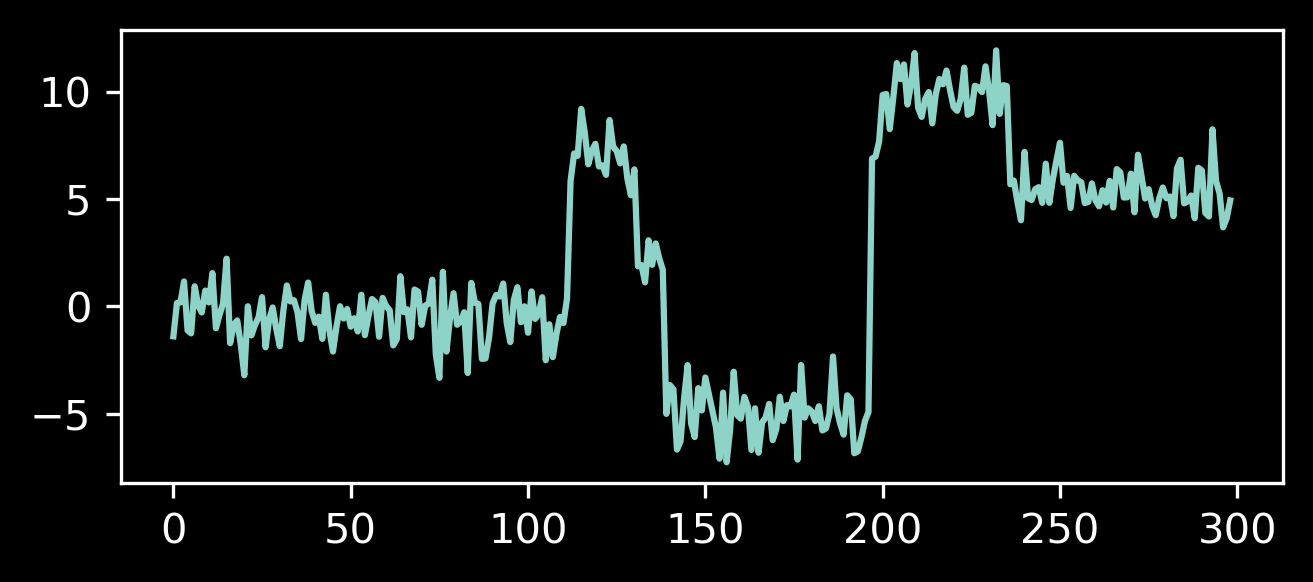

In [61]:
data = pd.read_csv("artificial_data_short.csv", delimiter=",").values.flatten()
with open("changepoints_short.txt", "rb") as fp:   # Unpickling
    cpts = pickle.load(fp)
    
fig, ax = plt.subplots(figsize=[5, 2])
ax.plot(data)

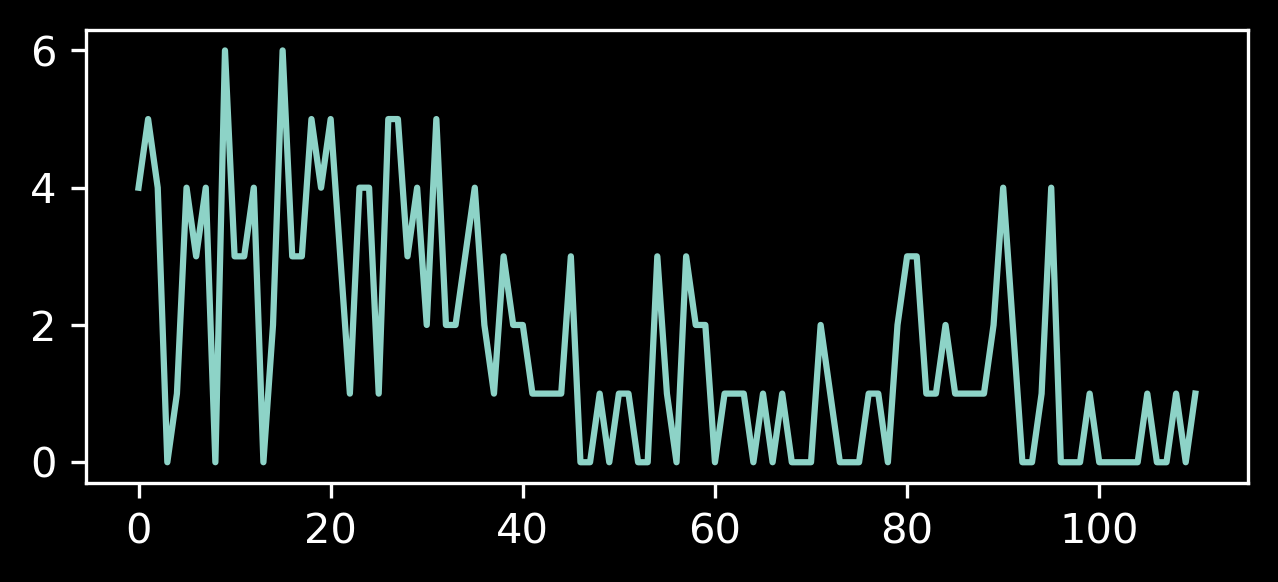

In [65]:
data = pd.read_csv("coalmining.csv", delimiter=";").values
fig, ax = plt.subplots(figsize=[5, 2])
cpts = [40, 98]
ax.plot(data)

In [37]:
#data = generate_normal_time_series(7, 50, 200)

#fig, ax = plt.subplots(figsize=[8, 5])
#ax.plot(data)

In [69]:
R, maxes = online_changepoint_detection(data, 1/250, StudentT(0.1, .01, 1, 0))

In [62]:
R, maxes = online_changepoint_detection(data, 1/250, Normal(0, 0.2))

In [66]:
R, maxes = online_changepoint_detection(data, 1/250, Poisson(1, 1))

In [48]:
R, maxes = online_changepoint_detection(data, 1/20, IS_Poisson_Gamma(1, 1, 1000))

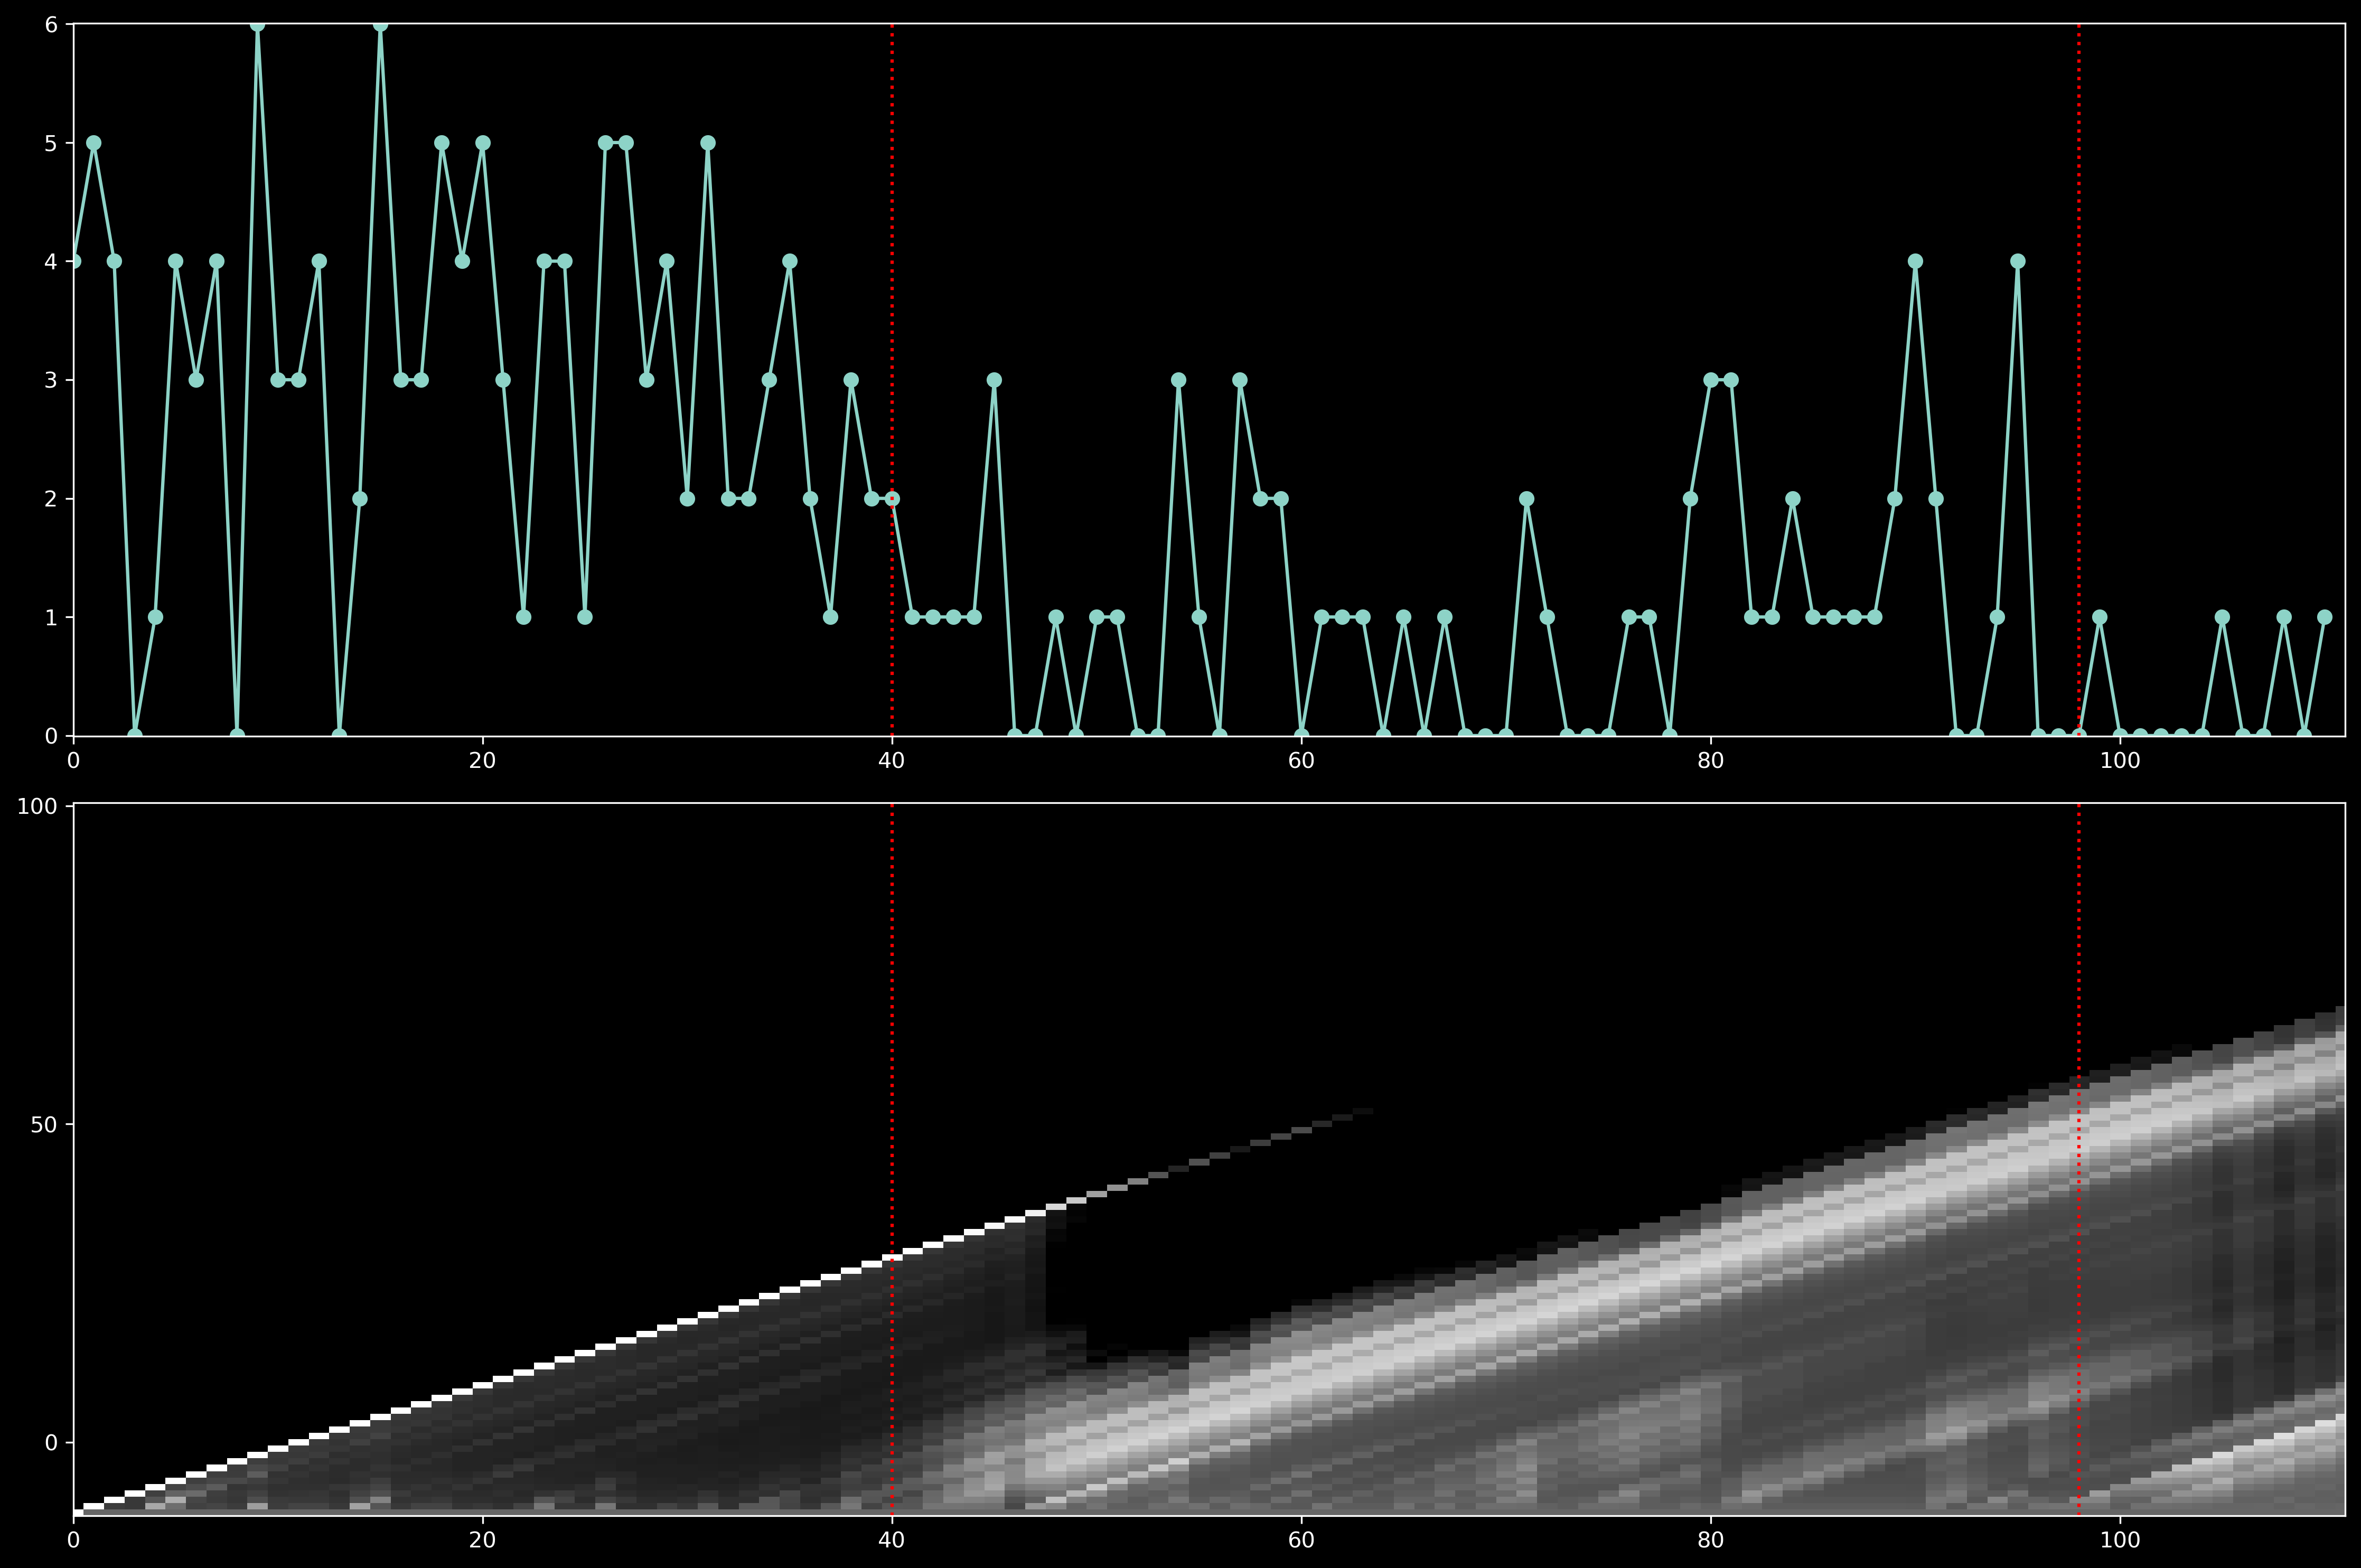

In [67]:
plot_posterior(len(data), data, R, cpts, set_cpts=True)

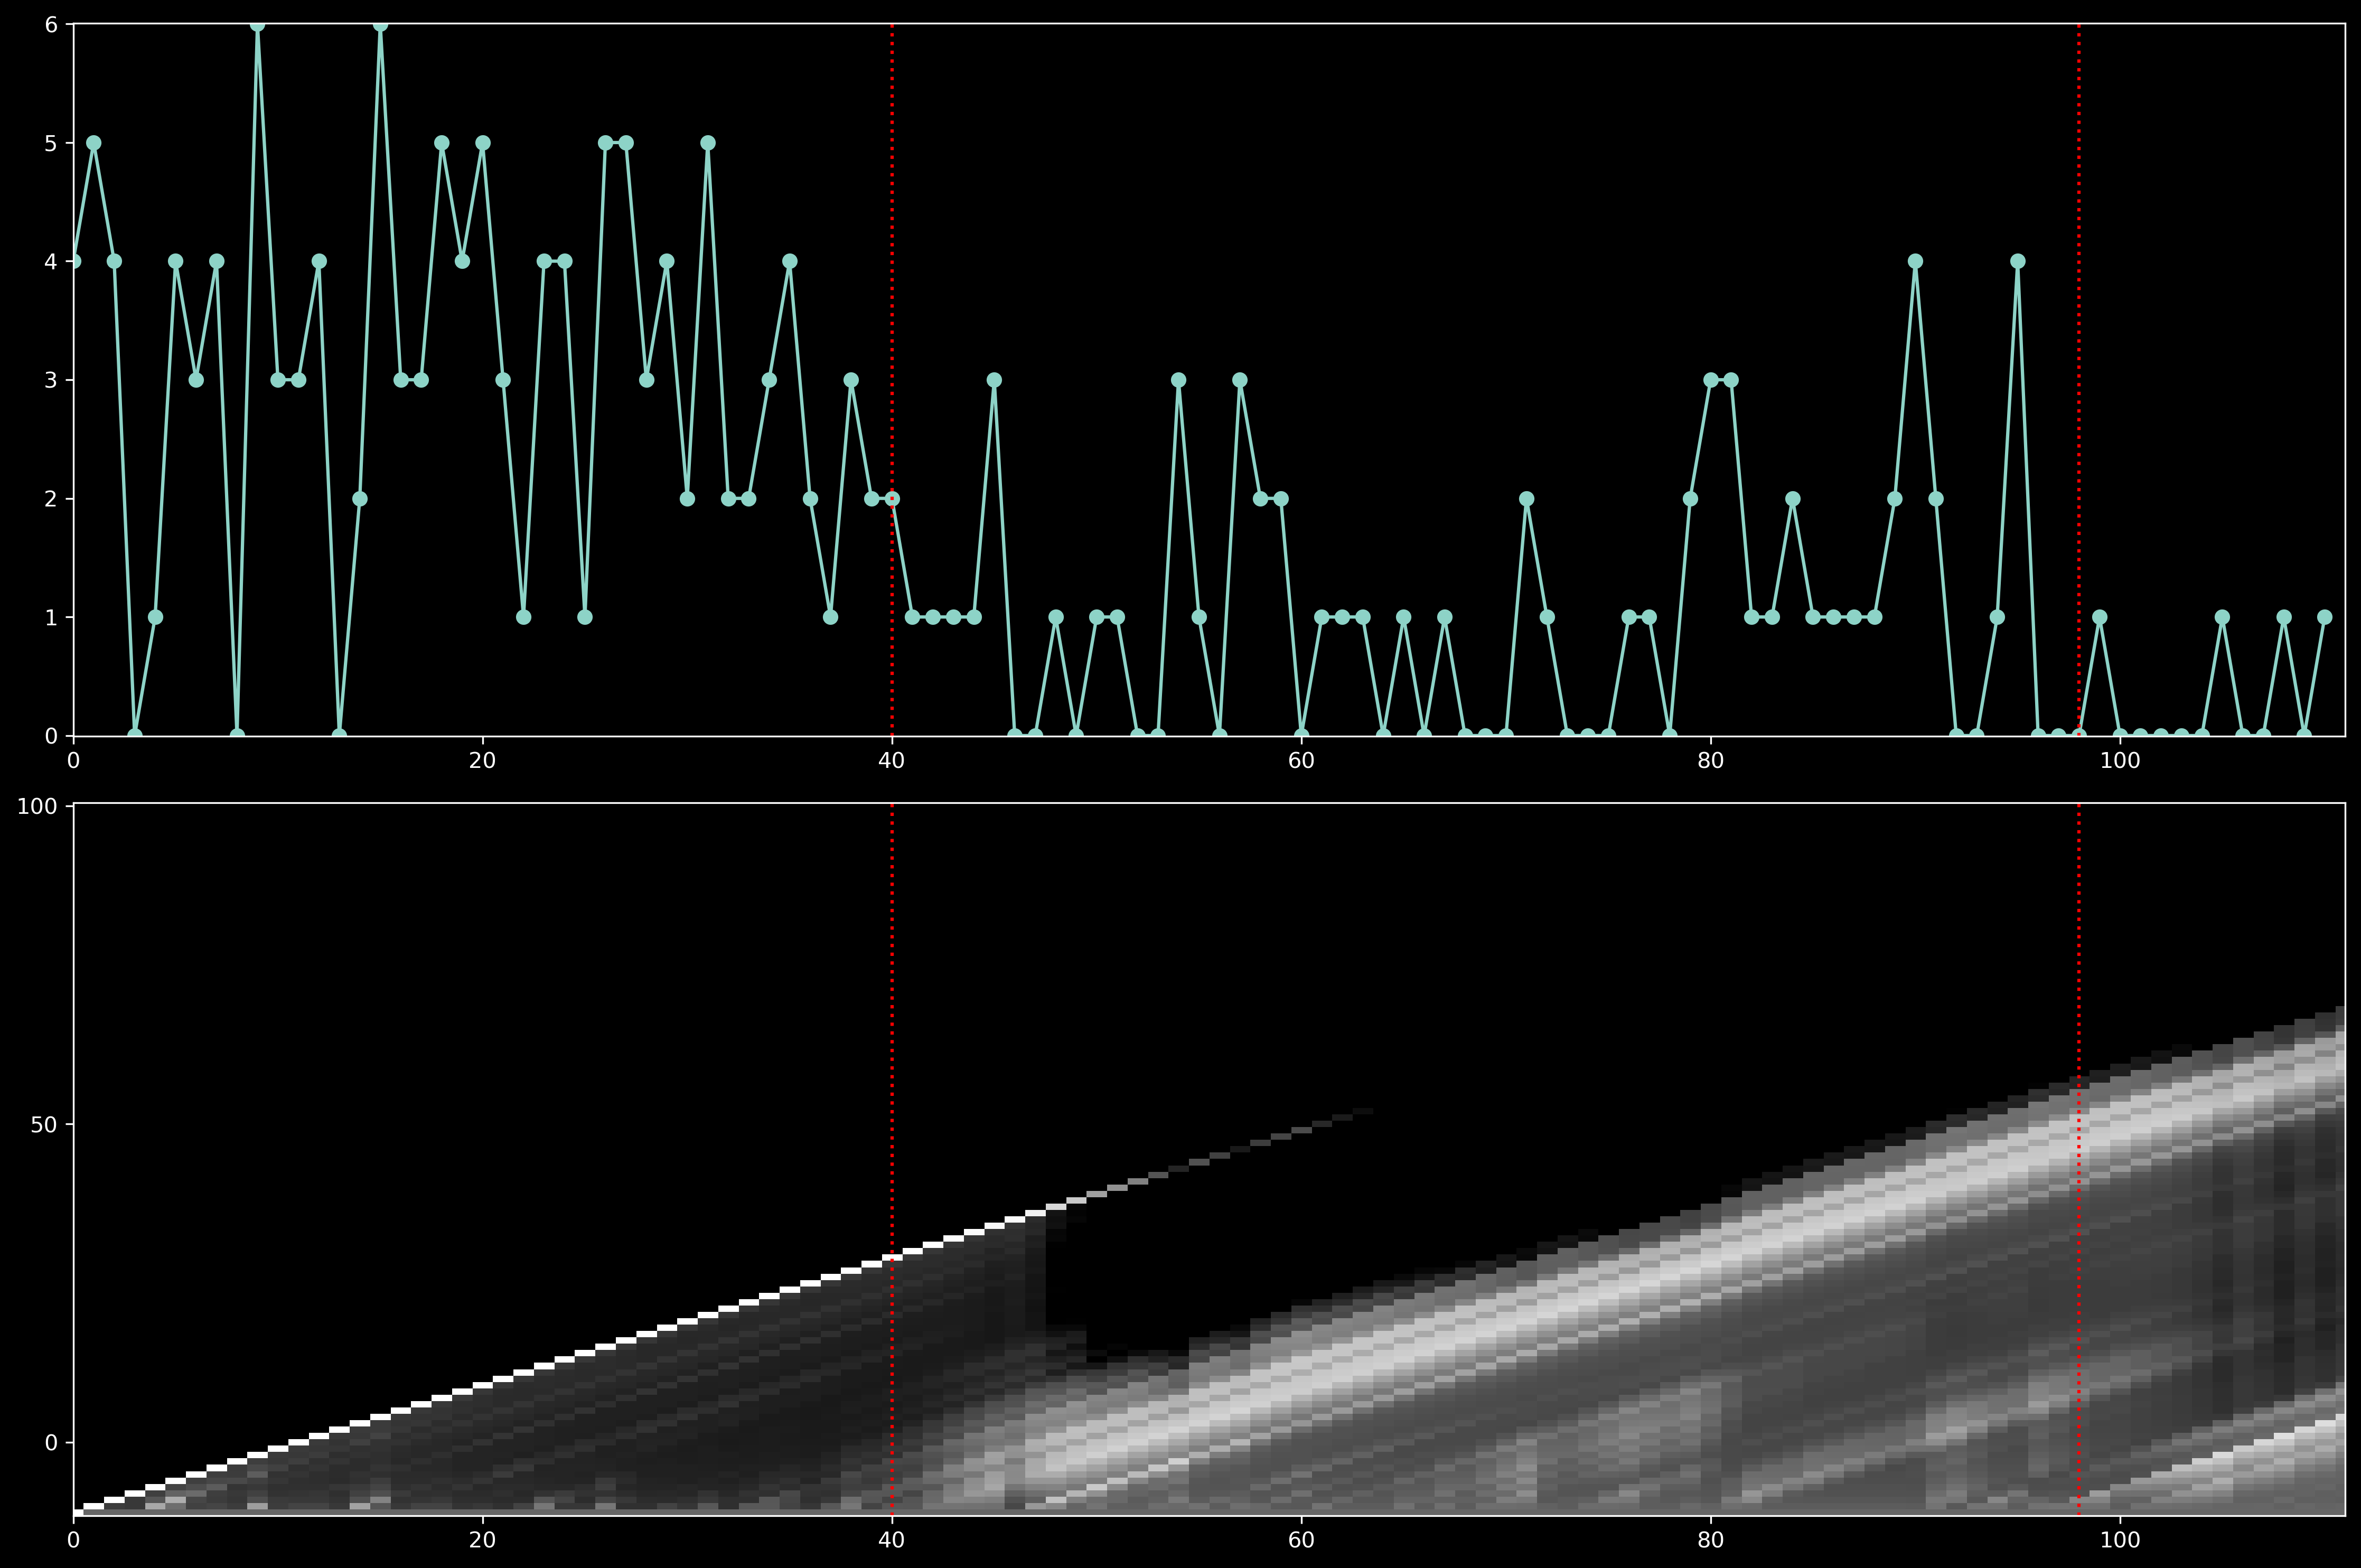

In [75]:
plot_posterior(len(data), data, R, cpts, set_cpts=True)

In [58]:
R[1:5,1:5]

array([[9.96000000e-01, 9.14477681e-04, 7.94213716e-04, 4.34138382e-02],
       [0.00000000e+00, 9.95085522e-01, 7.93484509e-04, 2.27027923e-03],
       [0.00000000e+00, 0.00000000e+00, 9.94412302e-01, 9.69949837e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.49345933e-01]])

In [76]:
R[0,:]

array([1.   , 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004,
       0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004,
       0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004,
       0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004,
       0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004,
       0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004,
       0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004,
       0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004,
       0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004,
       0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004,
       0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004,
       0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004,
       0.004, 0.004, 0.004, 0.004])

In [47]:
R[1:5,1:5]

array([[0.95      , 0.02627813, 0.02749359, 0.07422679],
       [0.        , 0.92372187, 0.02515772, 0.02543821],
       [0.        , 0.        , 0.89734869, 0.02318351],
       [0.        , 0.        , 0.        , 0.8271515 ]])

In [60]:
R[0,:]

array([1.   , 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004,
       0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004,
       0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004,
       0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004,
       0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004,
       0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004,
       0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004,
       0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004,
       0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004,
       0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004,
       0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004,
       0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004,
       0.004, 0.004, 0.004, 0.004])